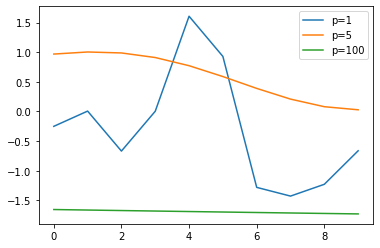

===y1===
[-0.25104714  0.00629301 -0.66849722  0.00370405  1.60713474  0.92883337
 -1.28102479 -1.42837937 -1.22911202 -0.66340208]
===y5===
[0.9688539  1.00396155 0.9875173  0.91018844 0.772365   0.5890854
 0.38919139 0.20845071 0.08020564 0.02826329]
===y10===
[-1.65510655 -1.66368592 -1.67218565 -1.68060148 -1.6889292  -1.69716449
 -1.70530302 -1.71334046 -1.72127238 -1.72909444]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor

def cov_matrix(x,p):
    l = x.shape[0]
    cov_m = np.zeros([l, l])
    for i in range(l):
        for j in range(l):
            cov_m[i, j] = np.exp(-np.sum((x[i]-x[j])**2) / (2*p**2))
    return cov_m

x = np.arange(10)
    
mean = np.zeros(x.shape)
y1 = np.random.multivariate_normal(mean, cov_matrix(x,1))
plt.plot(x, y1,label = "p=1")
    
y5 = np.random.multivariate_normal(mean, cov_matrix(x,5))
plt.plot(x, y5,label = "p=5")
    
y10 = np.random.multivariate_normal(mean, cov_matrix(x,100))
plt.plot(x, y10,label = "p=100")

plt.legend()
plt.show()
print("===y1===")
print(y1)

print("===y5===")
print(y5)
print("===y10===")
print(y10)


In [ ]:
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.optimize import minimize, Bounds

import pylab as pl 

# ----------------------------------------------------------------------------        
class dataset:
    def __init__(self, numSamples=500, verbose=False):
        digits = load_digits()
        self.X = digits.data[:numSamples]
        self.X /= np.max(self.X)
        self.y = digits.target[:numSamples]
        
        if(verbose == True):
            print("X looks like:")
            pl.gray()
            pl.matshow(digits.images[0]) 
            pl.show()
            print("X.shape:", self.X.shape)
            print("y.shape:", self.y.shape)
        
    def get_dataset(self):
        return (self.X, self.y)
# ----------------------------------------------------------------------------        
def eval_model(data, gamma, C):
    X, y = data
    clf = SVC(C=C, gamma=gamma)
    scores = cross_val_score(clf, X, y, cv=10)
    return 1-np.mean(scores)

# ----------------------------------------------------------------------------        
class bayesian_optimization:
    def __init__(self, data, numInitParams=20, verbose=False):
        print("bayesian_optimization initialing......")
        
        self.data = data
        self.trainParams = self.get_random_new_params(numInitParams)
        self.trainEvals = np.empty(self.trainParams.shape[0])
        for i, (c, gamma) in enumerate(self.trainParams):
            eval = eval_model(data, gamma, c)
            self.trainEvals[i] = eval           
        self.gp = GaussianProcessRegressor(kernel=RBF(), alpha=1e-4, normalize_y=True, n_restarts_optimizer=0, optimizer=None)
        self.gp.fit(self.trainParams, self.trainEvals)
        self.epsilon = 0.5
        
        if(verbose == True):
            print("trainParams:", self.trainParams)
            print("trainEvals:", self.trainEvals)
        
    def get_random_new_params(self, n):
        cs = np.abs(np.random.normal(0, 5, size=n))
        gammas = np.abs(np.random.normal(0, 1, size=n))
        return np.stack([cs, gammas], axis=-1)
    
    def objective(self, x, epsilon):
        # The objective function that should be minimized
        x = x[np.newaxis, ...]
        mean, std = self.gp.predict(x, return_std=True)
        return mean - epsilon*std
    
    def select_next_test_params(self, epsilon=0.5, numNewParams=20):
        # start the optimization from several random starting points, so we don't get stuck in a bad local optimum
        starts = self.get_random_new_params(numNewParams)

        # Keep the SVM parameters positive, otherwise the program will crash
        bounds = Bounds(1e-7, np.inf, True)
        best = float('inf')
        best_param = np.empty(2, dtype=np.float64)
        for start in starts:
            # If no gradient function is supplied, it is estimated via finite differences
            # in the optimization procedure
            res = minimize(self.objective, start, epsilon, method='L-BFGS-B', bounds=bounds)
            if res.fun < best:
                best = res.fun
                best_param = res.x

        mean, std = self.gp.predict(best_param[np.newaxis, ...], return_std=True)

        return best_param[0], best_param[1], mean[0], std[0]
    
    def start_optimizing(self, iteration=10):
        for i in range(iteration):
            new_c, new_gamma, pred_mean, pred_std = self.select_next_test_params(numNewParams=20)
            print('Process selected c={:.5f} and gamma={:.5f}. Predicted mean={:.5f}, std={:.5f}'.format(new_c, new_gamma, pred_mean, pred_std))
            newParams = np.array([[new_c, new_gamma]])
        
            if np.any(np.all(np.abs(self.trainParams - newParams) <= 1e-7, axis=-1)):
                print('Duplicate Detected, choosing random instead!')
                newParams = self.get_random_new_params(1)
                new_c, new_gamma = newParams[0]

            eval = eval_model(self.data, new_gamma, new_c)
            print('True CV Error is {:.5f}.'.format(eval))
            self.trainParams = np.concatenate([self.trainParams, newParams], axis=0)
            self.trainEvals = np.append(self.trainEvals, eval)
            self.gp.fit(self.trainParams, self.trainEvals)
        
        print("--------------------------------")
        final_c, final_gamma, mean, std = self.select_next_test_params(epsilon=0, numNewParams=20)
        print('Process selected c={:.5f} and gamma={:.5f} as final parameters. Predicted mean={:.5f}, std={:.5f}'.format(new_c, new_gamma, pred_mean, pred_std))
        eval = eval_model(self.data, final_gamma, final_c)
        print('True CV Error is {:.5f}.'.format(eval))

# ----------------------------------------------------------------------------            
if __name__ == '__main__':
    ds = dataset(numSamples=500, verbose=True)
    data = ds.get_dataset()
        
    ## you sould select random Cs and gammas and evaluate the CV error using the function eval_model above

    ## here you create the evaluations data matrix with first and
    ## second columns are gammas and Cs and the lst column is the true function evaluations at those gammas and Cs

    bo = bayesian_optimization(data, numInitParams=20, verbose=True)
    
    ## Then you should call the select_next_test_point that you will implement and append the selected gamma and C as well as their evaluation
    ## using eval_model to the evaluations matrix and repeat N times.
    
    ## Finally, select the point (gamma,C) that minimize the gaussian process prediction without caring about the standard deviation that is with epsilon  = 0
    ## and evaluate it with eval_model and report (gamma,C) and gaussian process evaluation and the true evaluation of eval_model
    bo.start_optimizing(100)
    
    print(bo.trainParams.shape)
    print(bo.trainEvals.shape)
    
   
   



   
    
